In [ ]:
pip install scikit-surprise

In [ ]:
#Import Libraries

import random
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import scipy

import seaborn as sns
sns.set()

from surprise.model_selection import cross_validate
from surprise import Dataset
from surprise import Reader
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering

In [ ]:
#Upload
from google.colab import files
uploaded = files.upload()

#Import courses
course_data = pd.read_csv("courses.csv")
course_data = course_data[['subj', 'lvl', 'course_no']]

Saving courses.csv to courses.csv


#Generate user "what they value" data


In [ ]:
centers = [(7,7,3,2,5),(7,7,3,8,5),(3,3,7,2,5),(3,3,7,8,5)]

X, y = make_blobs(n_samples=10000, cluster_std=1, centers=centers, n_features=5, random_state=0)

#X has shape (10000,5). 10000 students each have 5 "value" ratings
#y has shape (10000,). 10000 students each belong to 1 of 4 clusters

#Make X and y dataframes
user_values = pd.DataFrame(X)
user_blobs = pd.DataFrame(y)

#Add column with userid
userid = list(range(0,10000))

user_values['userid'] = userid
user_blobs['userid'] = userid

#the columns represent how much students value specific attributes courses can have
user_values.columns = ['critical_thinking','hands_on','reading_writing','difficulty','engaging','userid']
user_values

,critical_thinking,hands_on,reading_writing,difficulty,engaging,userid
0,8.626721,6.075530,2.844006,2.424998,4.220449,0
1,2.015049,3.240969,8.436163,2.879551,4.898822,1
2,3.665164,2.318416,6.961717,8.483894,5.724882,2
3,6.381175,8.028651,2.298954,7.428043,5.155366,3
4,2.450633,3.810702,7.511577,3.434992,4.737864,4
...,...,...,...,...,...,...
9995,6.112819,6.067211,4.243319,2.812674,5.587259,9995
9996,7.128314,7.447886,2.302456,2.165488,4.663717,9996
9997,7.536597,7.404695,3.191451,2.880511,4.545920,9997
9998,2.406479,4.290622,8.130348,3.821287,5.162763,9998


#Generate course "what values they satisfy" data

In [ ]:
#Grouping courses

#Group courses based on subject
math_courses = course_data.loc[course_data['subj'] == 'MAT']
english_courses = course_data.loc[course_data['subj'] == 'ENG']
bio_courses = course_data.loc[course_data['subj'] == 'BIO']
chem_courses = course_data.loc[course_data['subj'] == 'CHE']
physics_courses = course_data.loc[course_data['subj'] == 'PHY']
compsci_courses = course_data.loc[course_data['subj'] == 'CSC']
history_courses = course_data.loc[course_data['subj'] == 'HIS']

#Group courses in larger categories
stem_courses = pd.concat([bio_courses,chem_courses, physics_courses, math_courses,compsci_courses])
humanities_courses = pd.concat([english_courses,history_courses])
language_courses = course_data[course_data['subj'].isin(['LAT','GRK','CHI','SPA','RUS','GER','JPN','FRE','ARA','ITA'])]
elective_courses = course_data[course_data['subj'].isin(['MUS','REL','HHD','THR','ART','INT','EXI','ECO','DAN','PSY','ANT','EPS'])]

#Add columns in course_data dataframe
course_data['critical_thinking']=""
course_data['hands_on']=""
course_data['reading_writing']=""
course_data['difficulty']=""
course_data['engaging']=""

#Assign critical-thinking scores
for ind in course_data.index:
  if course_data.loc[ind,'course_no'] in stem_courses.values:
    course_data.loc[ind,'critical_thinking'] = np.random.normal(8,2)
  elif course_data.loc[ind,'course_no'] in language_courses.values:
    course_data.loc[ind,'critical_thinking'] = np.random.normal(3,2)
  else:
    course_data.loc[ind,'critical_thinking'] = np.random.normal(5,3)

#Assign hands-on scores
for ind in course_data.index:
  if course_data.loc[ind,'course_no'] in stem_courses.values:
    course_data.loc[ind,'hands_on'] = np.random.normal(6,2)
  elif course_data.loc[ind,'course_no'] in elective_courses.values:
    course_data.loc[ind,'hands_on'] = np.random.normal(4,2)
  else:
    course_data.loc[ind,'hands_on'] = np.random.normal(2,3)

#Assign reading and writing scores
for ind in course_data.index:
  if course_data.loc[ind,'course_no'] in stem_courses.values:
    course_data.loc[ind,'reading_writing'] = np.random.normal(2,2)
  elif course_data.loc[ind,'course_no'] in humanities_courses.values:
    course_data.loc[ind,'reading_writing'] = np.random.normal(7,2)
  else:
    course_data.loc[ind,'reading_writing'] = np.random.normal(5,1.5)

#Assign difficulty scores
for ind in course_data.index:
  if course_data.loc[ind,'lvl'] >= 500:
    course_data.loc[ind,'difficulty'] = np.random.normal(8,2)
  elif course_data.loc[ind,'lvl'] == 400:
    course_data.loc[ind,'difficulty'] = np.random.normal(6,2)
  elif course_data.loc[ind,'lvl'] == 300:
    course_data.loc[ind,'difficulty'] = np.random.normal(4,2)
  else:
    course_data.loc[ind,'difficulty'] = np.random.normal(2,3)

#Assign engaging scores
for ind in course_data.index:
  course_data.loc[ind,'engaging'] = np.random.normal(5,4)

#Generate user courseload data

In [ ]:
electives = ['ART', 'HIS', 'LAT', 'GRK', 'CSC', 'ANT', 'CHI', 'FRE', 'GER', 'JPN', 'RUS', 'SPA', 'MUS', 'REL', 'BIO',
             'CHE', 'EPS', 'PHY', 'DNC', 'THR', 'ECO', 'EXI', 'INT', 'ARA', 'ITA', 'PSY', 'BIO', 'CHE', 'PHY', 'HHD']

lvl_req_stem = ['MAT', 'BIO', 'CHE', 'PHY']

#cleaning up the data to reflect realistic course choices for uppers & seniors
subjects = course_data.subj
course_data = course_data.drop(course_data[(course_data.lvl < 400) & (subjects == 'ENG')].index)
course_data = course_data.drop(course_data[(course_data.lvl < 400) & (subjects == 'REL')].index)
course_data = course_data.drop(course_data[(course_data.lvl < 300) & (subjects.isin(lvl_req_stem))].index)
course_data = course_data.drop(course_data[(course_data.lvl < 300) & (subjects == 'HIS')].index)
display(course_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


,subj,lvl,course_no,critical_thinking,hands_on,reading_writing,difficulty,engaging
0,ART,200,ART202,1.314739,0.803359,4.913195,3.03643,2.896466
1,ART,200,ART203,4.666556,2.549742,3.966692,7.463097,10.740989
2,ART,200,ART205,6.996957,3.812122,7.176752,-4.404752,5.393006
3,ART,200,ART206,0.919312,-0.048213,3.116874,2.138056,1.296491
4,ART,200,ART208,2.428685,6.60498,5.302107,2.834877,4.616518
...,...,...,...,...,...,...,...,...
478,THR,300,THR300,5.804271,4.309265,5.906894,4.191102,4.489716
479,THR,300,THR303,2.058854,-0.096029,5.52868,3.985341,1.078731
480,THR,400,THR404,4.60193,3.433903,7.648599,5.183253,10.046284
481,THR,400,THR405,4.209488,2.770961,5.064628,8.493849,0.506994


In [ ]:
#Generating users
user_ids = list(range(0, 10000))

#Extracting courses by subject
math_courses = course_data.loc[course_data['subj'] == 'MAT']
english_courses = course_data.loc[course_data['subj'] == 'ENG']
bio_courses = course_data.loc[course_data['subj'] == 'BIO']
chem_courses = course_data.loc[course_data['subj'] == 'CHE']
physics_courses = course_data.loc[course_data['subj'] == 'PHY']
other_courses = course_data.loc[course_data['subj'].isin(electives)]

#generating a course load for a given user
def five_courses(user_id):
  math = math_courses.sample().values[0][2]
  english = english_courses.sample().values[0][2]
  science = pick_science().values[0][2]
  elective1, elective2 = pick_electives()
  user_courses = [math, english, science, elective1, elective2]
  return user_courses

#picking a science class
def pick_science():
  branch = random.randint(0, 2)
  if branch == 0:
    return bio_courses.sample()
  if branch == 1:
    return chem_courses.sample()
  if branch == 2:
    return physics_courses.sample()

#picking two electives in a realistic way
def pick_electives():
  elective1 = other_courses.sample().values[0]
  elective2 = other_courses.sample().values[0]
  while (elective1[0] == elective2[0]):
    elective1 = other_courses.sample().values[0]
  return elective1[2], elective2[2]

#generate more course data for each user by choosing twenty distinct courses instead of just five
def twenty_courses(user_id):
  user_twenty_courses = []
  while len(user_twenty_courses) < 20:
    temp = five_courses(user_id)
    for course in temp:
      if course in user_twenty_courses:
        break
      user_twenty_courses.append(course)
  return user_twenty_courses

#returns a list of all the courses for each user, to be later converted to a DataFrame
def get_courses():
  courses_by_user = []
  for user in user_ids:
    courses_by_user.append(twenty_courses(user))
  return courses_by_user

user_course_data = pd.DataFrame(get_courses())
user_course_data.drop(user_course_data.iloc[:, 20:24], inplace = True, axis = 1) #getting rid of any extra columns added on by twenty_courses
user_course_data.columns = ['Course1', 'Course2', 'Course3', 'Course4', 'Course5', 'Course6', 'Course7', 'Course8', 'Course9', 'Course10',
                            'Course11', 'Course12', 'Course13', 'Course14', 'Course15', 'Course16', 'Course17', 'Course18', 'Course19', 'Course20']
user_course_data.insert(0, 'userid', user_ids) #adding userids to the DataFrame
display(user_course_data)

#convert into .csv file -- uncomment next two lines
#user_course_data.to_csv('user_course_data.csv', index=False)
#files.download('user_course_data.csv')

,userid,Course1,Course2,Course3,Course4,Course5,Course6,Course7,Course8,Course9,Course10,Course11,Course12,Course13,Course14,Course15,Course16,Course17,Course18,Course19,Course20
0,0,MAT40D,ENG559,BIO670,LAT210,CHE431,MAT410,ENG579,CHE320,CHE310,ART405,MAT42S,ENG540,BIO470,LAT771,THR502,MATTR4,MAT32T,MAT511,ENG570,BIO486
1,1,MAT42S,ENG545,CHE530,BIO465,GRK130,MAT431,ENG568,PHY450,FRE503,GER111,MAT310,ENG567,CHE520,GER502,CHI111,MAT640,ENG587,CHE460,BIO475,SPA400
2,2,MAT610,ENG506,PHY320,HIS506,ART690,MAT310,ENG583,BIO586,EXI559,CHE330,MAT400,ENG430,CHE640,HHD504,MUS410,MAT42S,ENG539,CHE431,JPN120,LAT320
3,3,MAT410,ENG543,PHY450,ARA121,FRE400,MAT34T,ENG555,CHE411,GRK631,SPA130,MAT320,ENG587,BIO586,FRE320,INT519,MAT400,ENG430,BIO460,BIO455,MUS200
4,4,MAT421,ENG552,CHE411,BIO480,ART203,MAT431,ENG578,BIO485,LAT721,ANT500,MAT590,ENG577,BIO520,CHI231,HIS430,MAT42C,ENG585,MAT420,ENG587,PHY450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,MAT34T,ENG506,PHY520,MUS203,THR201,MAT41C,ENG549,PHY510,PHY310,ITA121,MAT41S,ENG505,BIO670,MUS085,ART208,MAT411,ENG545,BIO530,GRK511,CHI521
9996,9996,MAT40X,ENG585,CHE431,MUS200,JPN130,MAT41X,ENG500,CHE450,MUS070,JPN504,MAT520,ENG567,PHY470,ITA131,LATTR2,MAT330,ENG540,PHY480,RUS320,JPN502
9997,9997,MATTR4,ENG572,PHY460,HIS308,CHE411,MAT321,ENG587,CHE510,HHD120,HIS410,MAT410,ENG586,BIO470,HIS550,HHD230,MAT401,MAT521,ENG582,CHE431,INT552
9998,9998,MAT41X,ENG505,PHY520,FRE555,RUS590,MAT41S,ENG503,PHY400,HIS302,CHI311,MAT690,ENG590,CHE450,THR203,SPA590,MAT31X,ENG576,CHE310,THR202,FRE552


In [ ]:
#Reshape courseload dataframe
df = user_course_data

df = df.melt(id_vars = ['userid'])
df = df.drop(columns = 'variable')
df.columns=['userid','courseid']

In [ ]:
df

,userid,courseid
0,0,MAT40D
1,1,MAT42S
2,2,MAT610
3,3,MAT410
4,4,MAT421
...,...,...
199995,9995,CHI521
199996,9996,JPN502
199997,9997,INT552
199998,9998,FRE552


In [ ]:
#merging user values data with course values data into same dataframe & cleaning up unnecessary columns
temp = df[["userid", "courseid"]]
temp = temp.merge(user_values, on="userid").merge(course_data, left_on="courseid", right_on="course_no")
temp = temp.drop(columns=["subj","lvl", "course_no"])
user_cols = ["critical_thinking_x",	"hands_on_x",	"reading_writing_x",	"difficulty_x",	"engaging_x"	]
course_cols = ["critical_thinking_y",	"hands_on_y",	"reading_writing_y",	"difficulty_y",	"engaging_y"	]

# Generate course rating using cosine similarity

In [ ]:
#Calculating cosine similarity between an user's value vector and a course's value vector
similarities = pd.DataFrame(columns = ['cos_sim'])

a = np.array(temp.loc[:,user_cols])
b = np.array(temp.loc[:,course_cols])

dot = np.multiply(a,b)
dot = np.sum(dot,axis=1)

b = b.astype(float)

abs_a = np.sqrt(np.sum(np.square(a),axis=1))
abs_b = np.sqrt(np.sum(np.square(b),axis=1))

denom = np.multiply(abs_a, abs_b)

cos_sim = np.divide(dot,denom)

In [ ]:
#Calculating ratings from cosine similarity scores. The more "similar" an user and course, the higher the rating would be.
ratings = pd.DataFrame((cos_sim - cos_sim.mean())/cos_sim.std())

In [ ]:
ratings

,0
0,0.424287
1,0.468899
2,0.730118
3,0.065312
4,-0.369775
...,...
199995,0.796535
199996,0.615161
199997,0.300156
199998,-0.75396


In [ ]:
#Add ratings to existing dataframe
df["rating"] = ratings

In [ ]:
#Determine max and min ratings
max = df["rating"].max()
min = df["rating"].min()

In [ ]:
# Download a copy of the generated rating data
df.to_csv('ratings.csv', index=False) 
files.download('ratings.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Visualizing rating data


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


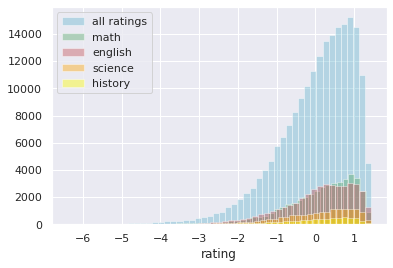

In [ ]:
#Visualize the distribution of ratings for courses of different subjects
mat = df[df['courseid'].str.contains("MAT")]
eng = df[df['courseid'].str.contains("ENG")]
sci = df[df['courseid'].str.contains("PHY" or "CHE" or "BIO")]
hist = df[df['courseid'].str.contains("HIS")]

sns.distplot(df['rating'], kde=False, color='c')
sns.distplot(mat['rating'], kde = False, color='g')
sns.distplot(eng['rating'], kde = False, color='r')
sns.distplot(sci['rating'], kde = False, color='orange')
sns.distplot(hist['rating'], kde = False, color='yellow')

plt.legend(['all ratings', 'math', 'english', 'science', 'history'])

# ML recommendation algorithm

In [ ]:
#Read data
reader = Reader(rating_scale=(min,max))
data = Dataset.load_from_df(df[['userid', 'courseid', 'rating']], reader)

In [ ]:
#Build trainset and train SVD algorithm
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset() #builds a test set such that there is no overlap with the data in the trainset
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

In [ ]:
#Display estimate ratings
estimates = pd.DataFrame(predictions, columns=['userid', 'courseid', 'rating', 'est', 'details'])
display(estimates)

,userid,courseid,rating,est,details
0,0,MAT610,5.803258e-14,-0.345046,{'was_impossible': False}
1,0,MAT421,5.803258e-14,0.026135,{'was_impossible': False}
2,0,MAT321,5.803258e-14,-0.074988,{'was_impossible': False}
3,0,MAT41S,5.803258e-14,-0.122362,{'was_impossible': False}
4,0,MAT43S,5.803258e-14,0.157233,{'was_impossible': False}
...,...,...,...,...,...
4179995,9999,JPN220,5.803258e-14,0.174727,{'was_impossible': False}
4179996,9999,HIS558,5.803258e-14,0.108431,{'was_impossible': False}
4179997,9999,GRK130,5.803258e-14,0.183001,{'was_impossible': False}
4179998,9999,RUS320,5.803258e-14,0.243536,{'was_impossible': False}


In [ ]:
from collections import defaultdict

def get_recs(predictions):
#map the predictions to each user
  top_five = defaultdict(list)
  for userid, courseid, true_r, est, _ in predictions:
    top_five[userid].append((courseid, est))
#sort the predictions for each user and retrieve the five highest ones
  for userid, user_ratings in top_five.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    top_five[userid] = user_ratings[:5]
  return top_five

In [ ]:
top_five = get_recs(predictions)

#full list of all recommended courses for each user
recommendations = pd.DataFrame(columns = ['userid','recommended'])
for userid, user_ratings in top_five.items():
  print(userid, [courseid for (courseid, _) in user_ratings])

Streaming output truncated to the last 5000 lines.
5000 ['BIO670', 'MAT41T', 'PHY520', 'MAT511', 'MAT521']
5001 ['BIO586', 'LAT791', 'ENG549', 'ENG502', 'ENG584']
5002 ['PHY470', 'ENG579', 'PHY530', 'MAT310', 'SPA210']
5003 ['REL598', 'PHY470', 'MAT521', 'ENG579', 'MAT41S']
5004 ['MAT43C', 'BIO460', 'MAT41T', 'ART208', 'MAT610']
5005 ['MAT521', 'PHY470', 'MAT41X', 'ENG552', 'HIS504']
5006 ['HIS305', 'BIO475', 'ENG585', 'ENG572', 'GRK220']
5007 ['PHY460', 'MAT790', 'MAT690', 'ART206', 'JPN590']
5008 ['GRK631', 'MAT320', 'BIO485', 'MAT640', 'ENG587']
5009 ['MAT41T', 'MAT430', 'MAT41S', 'MAT41X', 'BIO510']
5010 ['PHY510', 'MAT40H', 'ENG576', 'GER130', 'HHD340']
5011 ['MAT42S', 'MAT41T', 'MAT40D', 'BIO590', 'BIO510']
5012 ['BIO330', 'MAT400', 'BIO485', 'MAT40X', 'MAT32T']
5013 ['MAT43S', 'ENG567', 'PHY330', 'MAT420', 'MAT640']
5014 ['MUS097', 'MAT411', 'THR502', 'ENG410', 'CSC308']
5015 ['MAT43S', 'CHI504', 'MAT40X', 'JPN220', 'ENG574']
5016 ['PHY320', 'MAT590', 'REL455', 'MAT31T', 'ENG559

# Verification by comparing to groundtruth (visuals involved)

In [ ]:
def generate_groundtruth(userid):
  #get the user's values
  values = user_values[user_values['userid']==userid].drop(columns=['userid'])
  user_matrix = pd.concat([values]*441, ignore_index=True)

  #get info on all courses
  courses = course_data.drop(columns=['subj','lvl'])
  cols = ["critical_thinking",	"hands_on",	"reading_writing",	"difficulty",	"engaging"	]

  #use cosine similarity to generate groundtruth ratings
  similarities = pd.DataFrame(columns = ['cos_sim'])
  a = np.array(user_matrix)
  b = np.array(courses.loc[:,cols])

  dot = np.multiply(a,b)
  dot = np.sum(dot,axis=1)

  b = b.astype(float)

  abs_a = np.sqrt(np.sum(np.square(a),axis=1))
  abs_b = np.sqrt(np.sum(np.square(b),axis=1))

  denom = np.multiply(abs_a, abs_b)

  cos_sim = np.divide(dot,denom)
  similarities = cos_sim
  
  ratings = pd.DataFrame((similarities - similarities.mean())/similarities.std())
    
  #df with course names and groundtruth ratings
  output = pd.DataFrame(courses['course_no'])
  output['actual_ratings'] = ratings
  output.columns = ['courseid','actual_ratings']

  #return list of courses sorted by rating
  output = output.sort_values(by=['actual_ratings'],ascending=False)
  return output
  

-0.0249673508579551


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


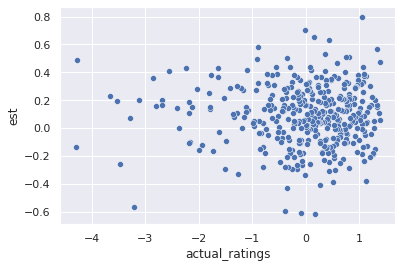

In [ ]:
#Function to graph scatter plot of actual and predicted ratings 
def compare_groundtruth_and_est(userid):
  test_stud = generate_groundtruth(userid)
  print(test_stud['actual_ratings'].mean())
  test_stud

  compare = test_stud
  compare = compare.merge(estimates[estimates['userid']==userid], on=["courseid"])
  compare = compare.drop(columns = ['rating','details'])

  sns.scatterplot(compare['actual_ratings'],compare['est'])

#Comparison of actual and predicted ratings for three sample students
compare_groundtruth_and_est(4444)
#compare_groundtruth_and_est(2222)
#compare_groundtruth_and_est(3333)

In [ ]:
def get_estimates(userid):
  user_est = estimates[estimates['userid']==userid]
  user_est = user_est.drop(columns = ['userid', 'rating','details'])
  return user_est

In [ ]:
#Percentage of course ratings that were estimated above the ground truth average -- another metric
def get_percent_above_avg(user_id):
  number_correct = 0
  number_total = 5
  gt = generate_groundtruth(user_id)

  for course in top_five.get(user_id):
    est_rating = get_estimates(user_id)[get_estimates(user_id)['courseid'] == course[0]]['est']
    est_rating = est_rating.values
    if est_rating >= (gt['actual_ratings'].mean() + 0.52):
      number_correct += 1
  return ((number_correct/number_total)*100)

some_percentages = []
for user in range(1,100):
  some_percentages.append(get_percent_above_avg(user))

In [ ]:
get_percent_above_avg(4300)

100.0

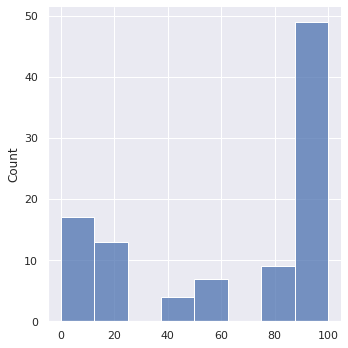

In [ ]:
sns.displot(some_percentages)

In [ ]:
#get top courses for single user
userid = int(input("Enter your user ID: "))
for course in top_five.get(userid):
  print(course[0])

Enter your user ID: 100
PHY530
MAT40J
ENG576
ENG568
BIO470
